# 4章 風景類似画像検索

## 風景画像の準備

GoogleDriveにkaggle.jsonを設定し、Colaboratoryからマウントしてください。

In [2]:
!ls drive/MyDrive/visual-search-book/landscape/kaggle.json

drive/MyDrive/visual-search-book/landscape/kaggle.json


In [3]:
!mkdir -p ~/.kaggle/
!cp drive/MyDrive/visual-search-book/landscape/kaggle.json ~/.kaggle

データのダウンロード

In [ ]:
!kaggle datasets download arnaud58/landscape-pictures
!unzip landscape-pictures.zip -d landscape-pictures

## ResNetを使った画像分類

モデルの初期化

In [7]:
import tensorflow as tf
model = tf.keras.applications.ResNet152(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)

242900992/242900224 [==============================] - 9s 0us/step


画像のロード

In [8]:
from tensorflow.keras.preprocessing import image
img_path = "/content/landscape-pictures/00000015.jpg"
img = image.load_img(img_path, target_size=(224, 224))

画像の表示

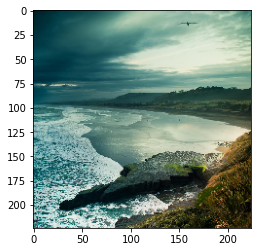

In [9]:
import matplotlib.pyplot as plt
plt.imshow(img)

画像の前処理

In [10]:
from tensorflow.keras.applications import resnet
x = image.img_to_array(img)
x = resnet.preprocess_input(x)

画像の推定

In [11]:
batch_tensor = tf.expand_dims(x, axis=0)
results = model.predict(batch_tensor)
resnet.decode_predictions(results, top=5)

40960/35363 [==================================] - 0s 0us/step


[[('n09428293', 'seashore', 0.49890733),
  ('n09399592', 'promontory', 0.21681315),
  ('n09246464', 'cliff', 0.1809939),
  ('n09421951', 'sandbar', 0.02358415),
  ('n09468604', 'valley', 0.017773954)]]

## 風景類似画像検索の実装

### インデックスの構築

全画像ファイルのパスを読み込み

In [12]:
import pathlib
dir_path = "/content/landscape-pictures/"
image_path_list = []
for img_path in pathlib.Path(dir_path).glob("*.jpg"):
    image_path_list.append(img_path)
image_path_list.sort()

行列形式への変換

In [14]:
import numpy as np
images = []
for img_path in image_path_list:
    img = image.load_img(img_path,
                         target_size=(224, 224))
    raw_image = image.img_to_array(img)
    images.append(raw_image)
images = np.array(images)

画像のサイズを表示

In [15]:
images.shape

(4319, 224, 224, 3)

モデルの読み込み

In [16]:
from tensorflow.keras.applications import resnet
model = tf.keras.applications.ResNet152(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling='avg',
    classes=1000
    )

234700800/234698864 [==============================] - 9s 0us/step


特徴ベクトルの作成

In [17]:
preprocessed = resnet.preprocess_input(images)
features = model.predict(preprocessed)

### 検索ロジックの作成

In [18]:
def cos_sim(v1, v2):
  return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def get_top_n_indexes(array, num):
  idx = np.argpartition(array, -num)[-num:]
  return idx[np.argsort(array[idx])][::-1]

def search(query_vector, features, num):
  sims = []
  for vector in features:
    sim = cos_sim(query_vector, vector)
    sims.append(sim)
  sims = np.array(sims)
  indexes = get_top_n_indexes(sims, num)
  return indexes, sims[indexes]

id=0で検索

In [19]:
query_id = 0
results, sims = search(features[query_id], features, 9)

可視化

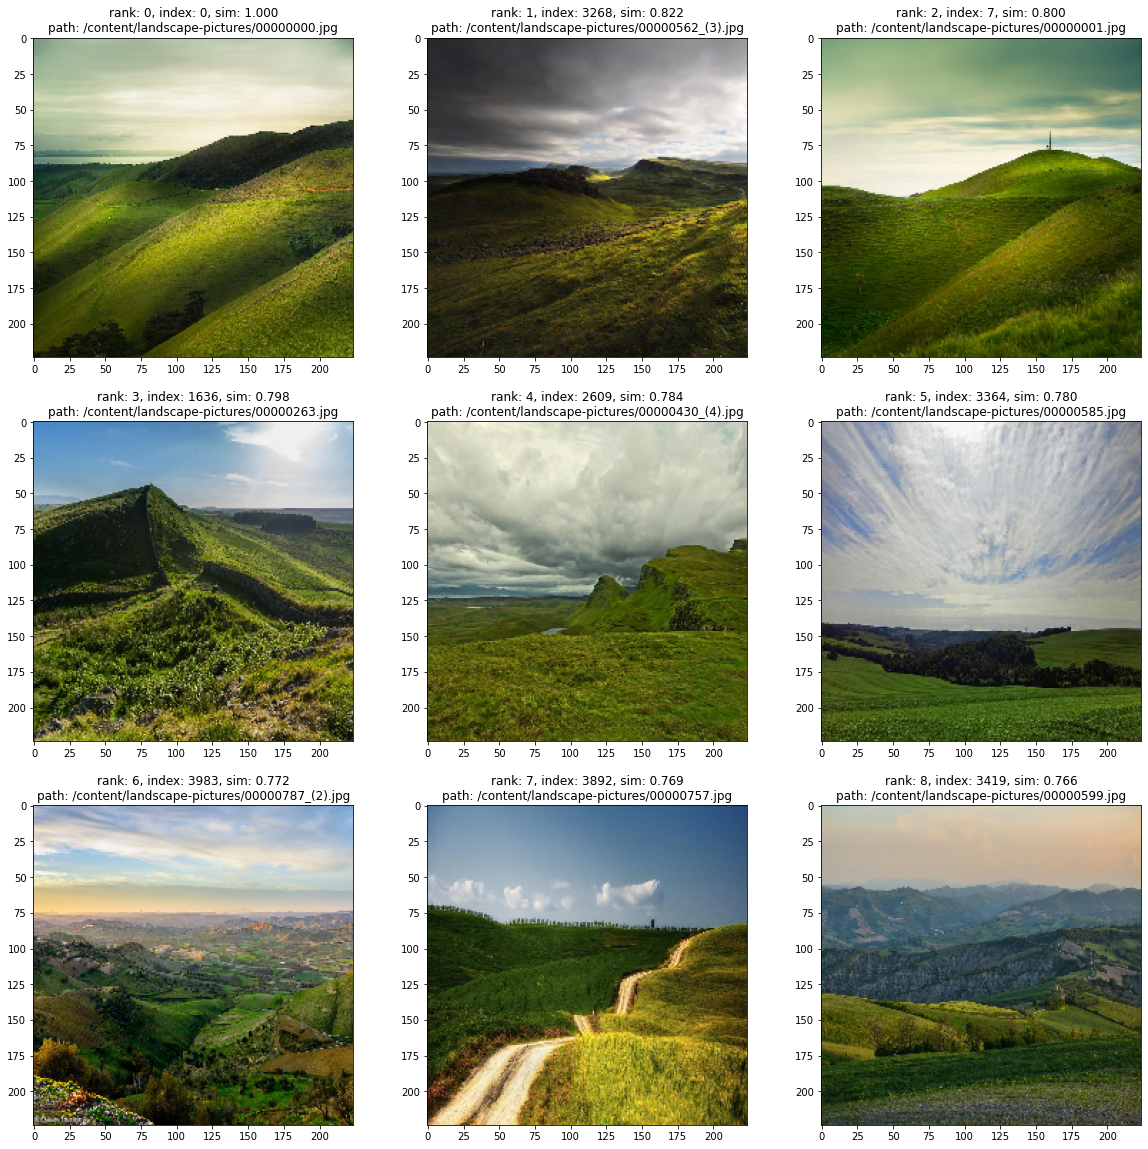

In [20]:
import matplotlib.pyplot as plt
rank = 0
plt.figure(figsize=(20, 20))

for idx, sim in zip(results, sims):
  plt.subplot(3, 3, rank+1)
  path = image_path_list[idx]
  title = f"rank: {rank}, index: {idx}, sim: {sim:.3f}\n"
  title += f"path: {path}"
  plt.title(title)
  img = image.load_img(image_path_list[idx],
                       target_size=(224, 224))
  plt.imshow(img)
  rank += 1

### 中間層の特徴ベクトルを利用
ここではconv5_block2_outを利用する例について記載します。

In [21]:
pooling = tf.keras.layers.GlobalAveragePooling2D()

def get_intermediate_model(layer_name):
  layer_model = model.get_layer(layer_name)
  pooling_output = pooling(layer_model.output)
  return tf.keras.Model(
    inputs=model.input, outputs=pooling_output)
  
# model_c4b36 = get_intermediate_model('conv4_block36_out')
model_c5b2 = get_intermediate_model('conv5_block2_out')

特徴ベクトルを取得

In [22]:
 features = model_c5b2.predict(preprocessed)

検索を実行

In [23]:
query_id = 0
results, sims = search(features[query_id], features, 9)

可視化

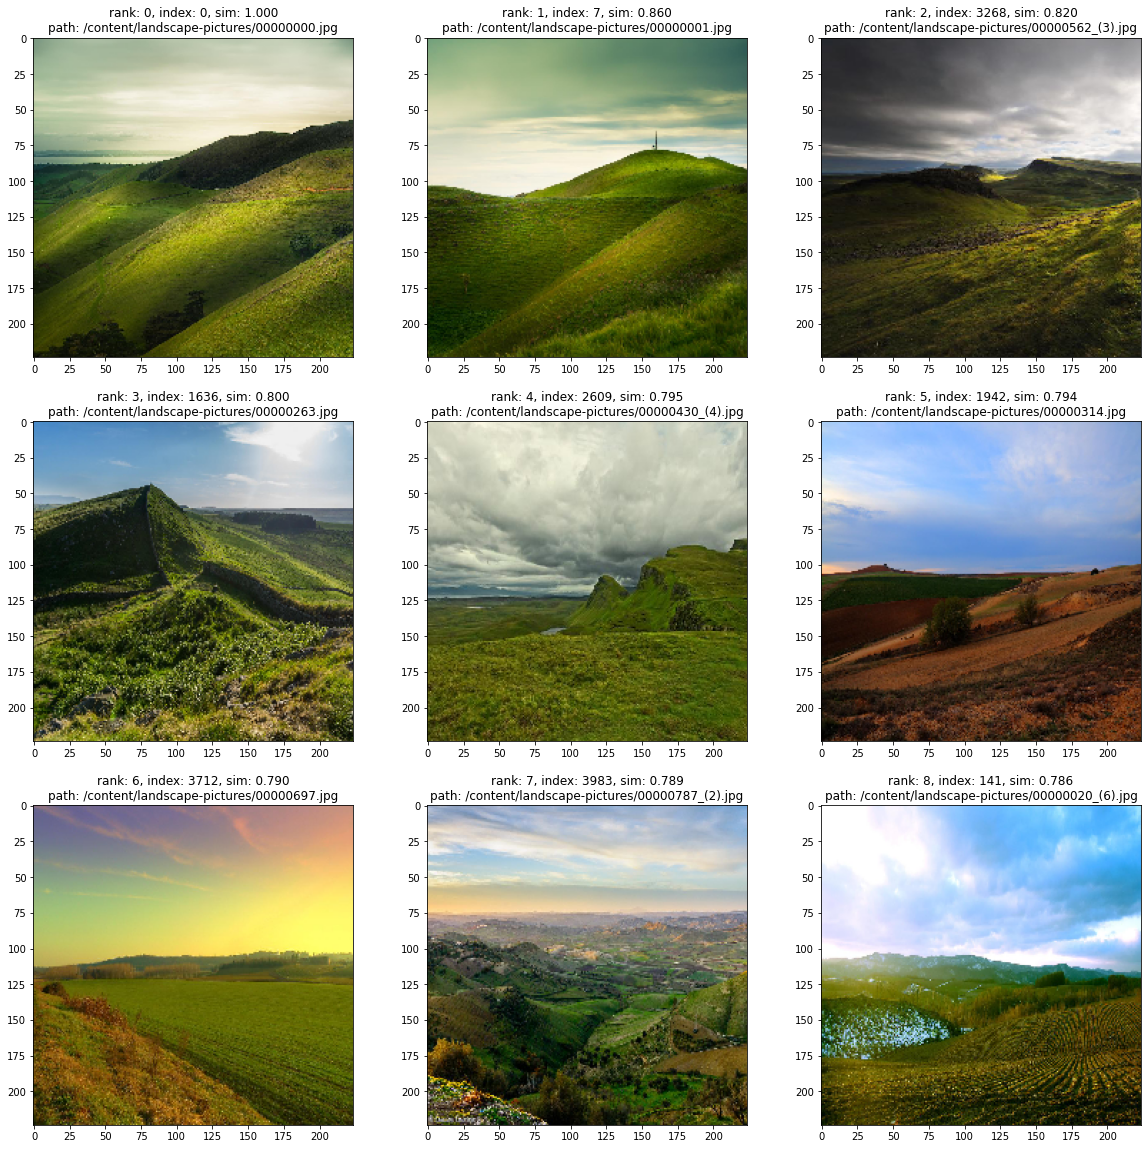

In [24]:
import matplotlib.pyplot as plt
rank = 0
plt.figure(figsize=(20, 20))

for idx, sim in zip(results, sims):
  plt.subplot(3, 3, rank+1)
  path = image_path_list[idx]
  title = f"rank: {rank}, index: {idx}, sim: {sim:.3f}\n"
  title += f"path: {path}"
  plt.title(title)
  img = image.load_img(image_path_list[idx],
                       target_size=(224, 224))
  plt.imshow(img)
  rank += 1